## 3D Spatially Correlated Synthetic Reservoir Generator

### Travis Salomaki, the University of Texas at Austin | [LinkedIn](https://www.linkedin.com/in/travissalomaki/)

## Motivation

This tool provides a method to generate semi-realistic synthetic reservoir data to support reservoir simulation efforts, spatial modeling, and machine learning workflows. In its current state, the program is able to generate permeability, porosity, depth, and thickness values for any x-y-z combination of grid block geometries. These values are then exported to your working directory as .txt files which can be used in any external modeling program or can be read back into python.
  
This project was created to support Dr. Matthew Balhoff at the University of Texas at Austin in the creation of a reservoir simulation textbook. This project would not be possible if not for Dr. Michael Pyrcz's geostatistical python library, ["GeostatsPy"](https://github.com/GeostatsGuy/GeostatsPy) which provides the technical backbone through which the simulated data is created. Additionally, the portions workflow that create the porosity and permeability values were borrowed from Dr. Michael Pyrcz's workflow titled ["GeostatsPy_synthetic_well_maker"](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/GeostatsPy_synthetic_well_maker.ipynb)


In [1]:
import geostatspy.GSLIB as GSLIB                          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                    # GSLIB methods convert to Python  
import os                                                 # operating system, set current working directory 
import matplotlib.pyplot as plt                           # plotting
import numpy as np                                        # arrays and matrix math
from mpl_toolkits.mplot3d import Axes3D                   # 3D scatter plots
import pandas as pd                                       # Dataframes
from scipy.optimize import minimize                       # Optimization method for Dykstra Parsons
from scipy.stats import mode                              # Used to find the mode during the optimization
import matplotlib.colors                                  # Color visualization
from matplotlib import cm
from sklearn.preprocessing import normalize
from mpl_toolkits.mplot3d import Axes3D
cmap = plt.cm.inferno

In [7]:
class SRS:
    def __init__(self):
        #Make sure that your working directory contains both the .ipynb file and the inputs.xlsx file
        self.import_params()
        self.build_variogram()
        return
    
    def import_params(self):
        '''
        Imports parameters from the excel file template
        '''
        try:
            name = input('What is the name of the input file? ')
            self.df_master = pd.read_excel(name,header = 1)
            self.df_master.iloc[:,3:9] = self.df_master.iloc[:,3:9].astype('float')
        except FileNotFoundError:
            print('File not found. Try again.')
        return 
    
    def set_current_params(self):
        '''
        Sets current parameters for use throughout the workflow within the SRS object
        '''
        self.nx = int(self.df['nx'])
        self.ny = int(self.df['ny'])
        self.nz = int(self.df['nz'])
        self.por_mean = self.df['por_mean']
        self.por_stdev = self.df['por_std']
        self.hsiz = self.df['hsiz']
        self.vsiz = self.df['vsiz']
        self.hrot = self.df['hor_ang']
        self.vrot = self.df['ver_ang']
        self.dp = self.df['DP']
        self.perm_mean = self.df['perm_mean']/100
        self.perm_stdev = self.df['perm_std']/100
        
        return
        
    def build_variogram(self):
        '''
        Generates the variogram model using the geostats library.
        Can change the variogram by altering the inputs below. 
        
        See GeostatsGuy Lectures on Data Analytics and Geostatistics for more information on variograms
        https://www.youtube.com/watch?v=pxckixOlguA&list=PLG19vXLQHvSB-D4XKYieEku9GQMQyAzjJ&ab_channel=GeostatsGuyLectures
        '''
        
        nst = 1;              #Number of structures within variogram (max is 3)
        azi = 0.0;            #Azimuth of variogram (0.0 is the y-axis, 90 is the x-axis)
        nug = 0.0;            #Magnitude of the nugget effect
        sill = 1              #Height of the sill        
        hmax = 150.0;         #Range in the major direction 
        hmin = 150.0;         #Range in the minor direction 
        hvert = 50            #Range in the vertical direction 

        # Make variogram object using GeostatsPy
        self.vario = geostats.make_variogram_3D(nug = 0.0,nst = nst,it1 = 1,cc1 = sill - nug,azi1 = azi,dip1 = 0.0,
            hmax1 = hmax,hmed1 = hmin,hmin1 = hvert)

        return
    
    def build_dummy(self):
        '''
        Creates a dummy array of values for use in the simulation.
        Determines the ultimate distribution of porosity values as set in the inputs excel file.
        '''
        vmin = self.por_mean - 4 * self.por_stdev; 
        vmax = self.por_mean + 4 * self.por_stdev
        
        null = np.zeros((200,4)).fill(-9999)
        self.df_dummy = pd.DataFrame(null, columns = ['X', 'Y', 'Z','Var'])
        self.df_dummy['Var'] = np.random.normal(loc = self.por_mean, scale = self.por_stdev, size = (200))
        print('Dummy Mean',str(np.average(self.df_dummy['Var'])))
        print('Dummy Stdev',str(np.std(self.df_dummy['Var'])))
        return
    
    def run_simulation(self):
        '''
        Runs the sequential gaussian simulation code using a randomly generated number seed.
        
        NOTE: This step may encounter errors if you do not have GSLIB properly installed on your device. 
        NOTE: For Mac users, see https://github.com/GeostatsGuy/GSLIB_MacOS for help installing the GSLIB executables.
        '''
        seed = np.random.randint(low = 1, high = 100000)
        self.sim = GSLIB.sgsim_3D(nreal=1, df=self.df_dummy, xcol='X', ycol='Y', zcol='Z', vcol='Var', nx=self.nx, ny=self.ny, nz=self.nz, 
                     hsiz=self.hsiz, vsiz=self.vsiz, seed=seed, var=self.vario, output_file="sgsim3d.out")
        self.sim = GSLIB.affine(self.sim,0,1)
        if self.nz != 1:
            self.sim = self.sim[0,:,:,:]
        print('The ndarray is indexed ireal, iy, ix, iz with size ' + str(self.sim.shape))
        return
    
    
    def transform_raw(self):
        '''
        Transforms the raw normal output from the sequential gaussian simulation to porosity and permeability values.
        
        Uses scipy's optimization library to change the b parameter seen below such that it produces a permeability
        array that has the desired dykstra parsons coefficient.
        
        This transformation alters the normal values such that the ultimate porosity distribution is gaussian and the
        permeability distribution is log-normal.
        
        Feel free to change the 'a' parameter and the 'c' parameter to get a different distribution. 
        '''
        
        normal = self.sim.flatten()
        results = np.zeros(100)
        a = 5.6; b = 5; c= 100; 
        
        #Function used to optimize dykstra-parsons.
        def mini(b):
            perm = (a * normal * normal) + (b*normal) + c
            perm = GSLIB.affine(perm,self.perm_mean,self.perm_stdev)*100
            fifty = np.quantile(perm.flatten(),q= .5)
            sixteen = np.quantile(perm.flatten(),q= .16)
            dp = (fifty-sixteen)/sixteen
            return abs(dp-.60)
        
        #Run the optimization program
        for i in np.arange(1,100):
            sol = minimize(mini,x0=i,method = 'Nelder-Mead',bounds = (0,None))
            results[i-1]=sol.x
        
        b_optimized = mode(results)[0][0]
        print('Optimized b parameter:', str(round(b_optimized,3)))
        
        #Uses the optimized 'b' parameter to transform the normal values. 
        self.por = GSLIB.affine(normal,self.por_mean,self.por_stdev)
        self.perm = (a * normal * normal) + (b_optimized*normal) + c
        self.perm = GSLIB.affine(self.perm,self.perm_mean,self.perm_stdev)*100
        
        #Calculates the dykstra-parsons coefficient 
        fifty = np.quantile(self.perm,q= .5)
        sixteen = np.quantile(self.perm,q= .16)
        print((fifty-sixteen)/sixteen)
        
        if self.nz == 1:
            self.perm = self.perm.reshape((self.nz,self.ny,self.nx))
            self.por = self.por.reshape((self.nz,self.ny,self.nx))
        else:
            self.perm = self.perm.reshape((self.ny,self.nx,self.nz))
            self.por = self.por.reshape((self.ny,self.nx,self.nz))

        return 
    
    def plot_layers(self,layers):
        '''
        INPUTS
        layers: how many layers to be plotted [int]

        OUTPUTS:
        plt.imshow plot of the horizontal slices
        '''

        for i in range(1,layers*2,2):
            for j in range(0,2):
                if j == 0:
                    #Perm
                    plt.subplot(layers,2,i)
                    data = self.perm
                    if data.shape[0] == 1:
                        im = plt.imshow(data[0,:,:], vmin = 0, vmax = max(data.flatten()),cmap = cmap) #Needs correct shape
                    else:
                        im = plt.imshow(data[:,:,i], vmin = 0, vmax = max(data.flatten()),cmap = cmap)
                    plt.title("Permeability" + ', Layer '+str((i+1)//2),fontsize = 16)  
                    cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
                    cbar.set_label("Permeability [mD]",rotation = 270,labelpad=17,fontsize = 14)

                elif j == 1:
                    plt.subplot(layers,2,i+1)
                    data2 = self.por
                    if data2.shape[0] == 1:
                        im2 = plt.imshow(data2[0,:,:], vmin = 0, vmax = max(data2.flatten()),cmap = cmap) #Needs correct shape
                    else:
                        im2 = plt.imshow(data2[:,:,i], vmin = 0, vmax = max(data2.flatten()),cmap = cmap)
                    plt.title("Porosity" + ', Layer '+str((i+1)//2),fontsize = 16)
                    cbar = plt.colorbar(im2,fraction=0.046, pad=0.04)
                    cbar.set_label("Porosity [%]",rotation = 270,labelpad=17,fontsize = 14)
                    
                plt.xlabel('X Grids',fontsize = 14)
                plt.ylabel('Y Grids',fontsize = 14)
                plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=3, wspace=0.3, hspace=0.2)
        return
    
    def plot_histogram(self):
        '''
        OUTPUTS
        Histogram of the desired property
        '''

        plt.subplot(121)
        plt.xlabel("Permeability [mD]",fontsize = 14)
        plt.hist(self.perm.flatten(),bins = 20,color = 'pink',edgecolor = 'black')
        plt.title('Permeability Distribution',fontsize = 16)
        plt.ylabel('Frequency',fontsize =14)
        
        plt.subplot(122)
        plt.xlabel("Porosity [%]",fontsize = 14)
        plt.hist(self.por.flatten(),bins = 20,color = 'pink',edgecolor = 'black')
        plt.title('Porosity Distribution',fontsize = 16)
        plt.ylabel('Frequency',fontsize =14)

        plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top= 1.5, wspace=0.2, hspace=0.3)

        return 
    
    def format_data(self):
        '''
        Creates export arrays of the permeabilty and porosity values.
        
        Starts from the bottom left corner of the bottom-most layer. 
        '''
        self.k_export = np.zeros(len(self.perm.flatten()))
        self.por_export = np.zeros(len(self.por.flatten()))
        n=0

        if self.nz == 1:
            for row in np.arange(self.ny-1,-1,-1):
                for col in np.arange(0,self.nx):
                    self.k_export[n] = self.perm[0,row,col]
                    self.por_export[n] = self.por[0,row,col]
                    n+=1
        else:
            for z in np.arange(0,self.nz):
                for row in np.arange(self.ny-1,-1,-1):
                    for col in np.arange(0,self.nx):
                        self.k_export[n] = self.perm[row,col,z]
                        self.por_export[n] = self.por[row,col,z]
                        n+=1
                    
        return 
    
    def make_center_pts(self,nx,ny,nz,hsiz,vsiz):
        '''
        Generates center points of every grid block.
        '''
        
        x_center = np.arange(0,nx)*hsiz
        x_center += hsiz*0.5

        y_center = np.arange(0,ny)*hsiz
        y_center += hsiz*0.5

        z_center = np.arange(0,nz)*vsiz
        z_center += vsiz*0.5

        return x_center,y_center,z_center
    
    
    def rotate(self,array,theta,axis):
        '''
        Used to rotate a 3D coordinate by an angle, theta, around a specified axis. 
        
        INPUTS
        array: x,y,z points to rotate
        theta: angle of rotation (use the right hand rule) [int]
        axis: which axis to rotate around, 'x','y',or 'z' [str]
        
        OUTPUTS
        array of rotated points 
        '''
        theta = np.radians(theta)
        rotation_y = np.array([[np.cos(theta),0,np.sin(theta)],[0,1,0],[-np.sin(theta),0,np.cos(theta)]])
        rotation_x = np.array([[1,0,0],[0,np.cos(theta),-np.sin(theta)],[0,np.sin(theta),np.cos(theta)]])
        rotation_z = np.array([[np.cos(theta),-np.sin(theta),0],[np.sin(theta),np.cos(theta),0],[0,0,1]])

        if axis == 'y':
            return np.dot(rotation_y,array)
        elif axis == 'x':
            return np.dot(rotation_x,array)
        elif axis == 'z':
            return np.dot(rotation_z,array)
        

    def generate_depths(self,shift,plot=False):
        '''
        Used to generate depth values and thickness values for export
        
        INPUTS
        shift: value to shift depths by [int]
        plot: boolean indicator for if you want to see the shifted depths and thickness values. 
        '''
        
        nx = self.nx; ny = self.ny; nz = self.nz
        hsiz = self.hsiz; vsiz = self.vsiz
        hrot = self.hrot; vrot = self.vrot
    
        x_pts, y_pts, z_pts = self.make_center_pts(nx,ny,nz,hsiz,vsiz)
        xx, yy, self.zz = np.meshgrid(x_pts,y_pts,z_pts)

        pts = pd.DataFrame(data = {'x':xx.flatten(),'y':yy.flatten(),'z':self.zz.flatten()})
        pts['xnew'] = pts['ynew'] = pts['znew'] = None
        new = np.zeros((nx*ny*nz,3))
        
        #Rotation
        for i in range(len(pts)):
            new[i] = self.rotate(pts.iloc[i,0:3].values,hrot,'z')
            new[i] = self.rotate(new[i,:],vrot,'y')

        pts.loc[:,['xnew','ynew','znew']] = new

        #Thickness
        distance = np.zeros((nx*ny*nz))

        xcenter = nx*hsiz/2
        ycenter = ny*hsiz/2

        distance[:] = np.sqrt(((pts['x']-xcenter)**2)+((pts['y']-ycenter)**2))
        normratio = ((distance[:] - min(distance))/(max(distance)-min(distance)))
        pts['Thickness'] = vsiz - (vsiz*0.75*normratio)
        
        #Plotting
        if plot == True:
            plt.subplot(121)
            plt.scatter(pts['x'],pts['y'],c = pts['z'])
            plt.scatter(pts['xnew'],pts['ynew'],c = -1*pts['znew'])
            plt.xlabel('X'); plt.ylabel('Y')
            color = plt.colorbar()
            color.set_label('Depth',rotation = 270,labelpad=20)

            plt.subplot(122)
            plt.scatter(pts['x'],pts['y'],c=pts['Thickness'],s = 70)
            plt.xlabel('x [ft]')
            plt.ylabel('y [ft]')
            plt.title('Thickness Demonstration')
            color = plt.colorbar()
            color.set_label('Thickness [ft]',rotation = 270,labelpad=20)
            plt.subplots_adjust(left=0.5, bottom=0.0, right=3, top=1.5, wspace=0.4, hspace=0.3)
        
        #Generate the depths
        self.depths = -1*pts['znew'].values 
        if min(self.depths) < 0:
            self.depths -= min(self.depths)
        self.depths += shift
        
        #Generate the thicknesses
        self.thickness = pts['Thickness'].values
        self.xnew = pts['xnew'].to_numpy()
        self.ynew = pts['ynew'].to_numpy()
        self.znew = pts['znew'].to_numpy()
        return 
    
    def set_axes_equal(self,ax):
        '''
        Make axes of 3D plot have equal scale so that spheres appear as spheres,
        cubes as cubes, etc..  This is one possible solution to Matplotlib's
        ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

        INPUTS
        ax: a matplotlib axis, e.g., as output from plt.gca().
        
        Credit to user 'Karlo' from stack overflow for this function.
        '''

        x_limits = ax.get_xlim3d()
        y_limits = ax.get_ylim3d()
        z_limits = ax.get_zlim3d()

        x_range = abs(x_limits[1] - x_limits[0])
        x_middle = np.mean(x_limits)
        y_range = abs(y_limits[1] - y_limits[0])
        y_middle = np.mean(y_limits)
        z_range = abs(z_limits[1] - z_limits[0])
        z_middle = np.mean(z_limits)

        # The plot bounding box is a sphere in the sense of the infinity
        # norm, hence I call half the max range the plot radius.
        plot_radius = 0.5*max([x_range, y_range, z_range])

        ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
        ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
        ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

        return
    
    
    def visualize(self,data):
        '''
        INPUTS
        data: either self.perm or self.por
        
        OUTPUTS
        Opens a new interactive window using ''%matplotlib qt' that allows for 3D rotation 
        and magnification of the reservoir. 
        '''
        %matplotlib qt
        nx,ny,nz = self.nx,self.ny,self.nz
        
        x,y,z = np.indices((ny,nx,nz))
        a,b,c = self.zz.shape
        filled = (x>=0) | (y>=0) | (z>=0)

        p = data.flatten()
        maxi = max(p);  mini = min(p)
        normalized = (p-mini)/(maxi-mini)
        colors = plt.cm.plasma(normalized)
        self.colors = colors
        colors = colors.ravel().reshape(a,b,c,4)

        ax = plt.figure().add_subplot(111,projection = '3d')
        plot = ax.voxels(filled,facecolors = colors)
        self.set_axes_equal(ax)

        norm = matplotlib.colors.Normalize(vmin=0, vmax=max(p))
        m = cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
        m.set_array([])
        cbar = plt.colorbar(m)

        ax.grid(False)
        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

        return
    
    def save_files(self):
        '''
        Saves the porosity, permeability, depth, and thickness values as individual .txt files in your working directory
        Each individual reservoir geometry (e.g. 20x30x2) will have a unique file containing all of the export files. 
        '''
        
        base = os.getcwd()
        name = str(self.nx)+'_'+str(self.ny)+'_'+str(self.nz)
        path = base + '/Exports'
        os.chdir(path)
        try:
            os.chdir(path+'/'+name)
        except: 
            os.mkdir(path+'/'+name)
            os.chdir(path+'/'+name)

        f = open('Permeability'+name,'w+')
        np.savetxt('Permeability'+name,self.k_export,delimiter=', ')
        f.close()

        f = open('Porosity'+name,'w+')
        np.savetxt('Porosity'+name,self.por_export,delimiter = ', ')
        f.close()

        f = open('Depth'+name,'w+')
        np.savetxt('Depth'+name,self.depths,delimiter = ', ')
        f.close()

        f = open('Thickness'+name,'w+')
        np.savetxt('Thickness'+name,self.thickness,delimiter = ', ')
        f.close()
        print('\nFiles Saved')
        os.chdir(base)
        return
    
    def master(self):
        '''
        Runs the workflow on each row of the input excel file and then saves the files
        '''
        for i in range(len(self.df_master)):
            self.df = self.df_master.iloc[i,:]
            self.set_current_params()
            self.build_dummy()
            self.run_simulation()
            self.transform_raw()
            self.format_data()
            self.generate_depths(0,plot = True)
            self.save_files()
            print('Completed Row '+str(i)+'\n')
        return
    
            

What is the name of the input file? inputs.xlsx
Dummy Mean 20.16382421533422
Dummy Stdev 2.720487375704427
The ndarray is indexed ireal, iy, ix, iz with size (1, 100, 100)
Optimized b parameter: 44.153
0.6000000261681594

Files Saved
Completed Row 0



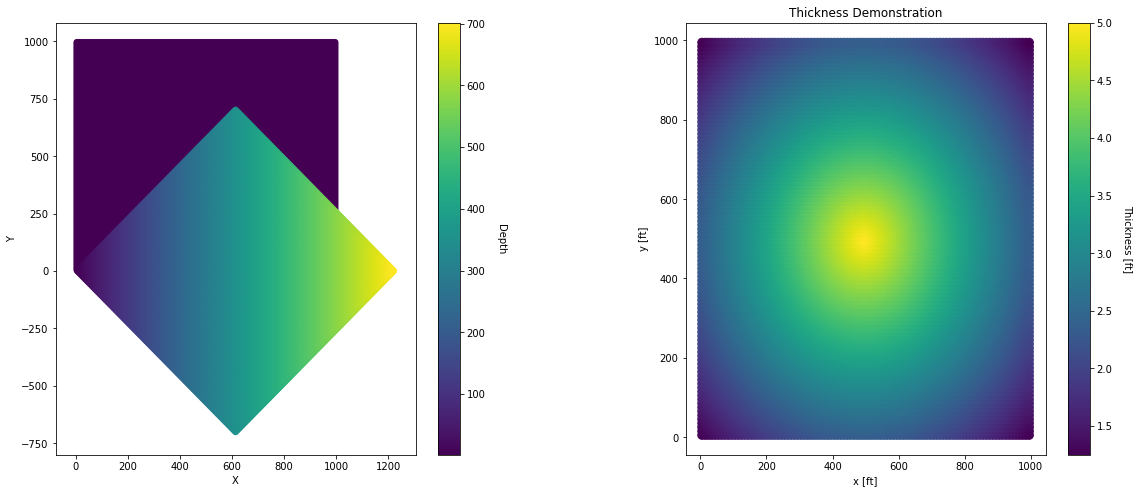

In [8]:
syntheticReservoir = SRS()
syntheticReservoir.master()

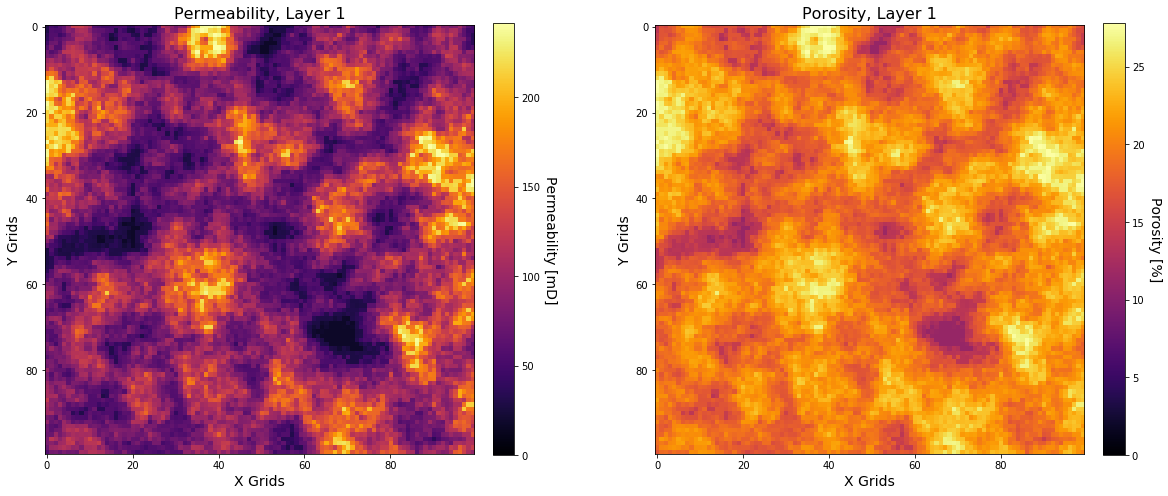

In [9]:
syntheticReservoir.plot_layers(1)

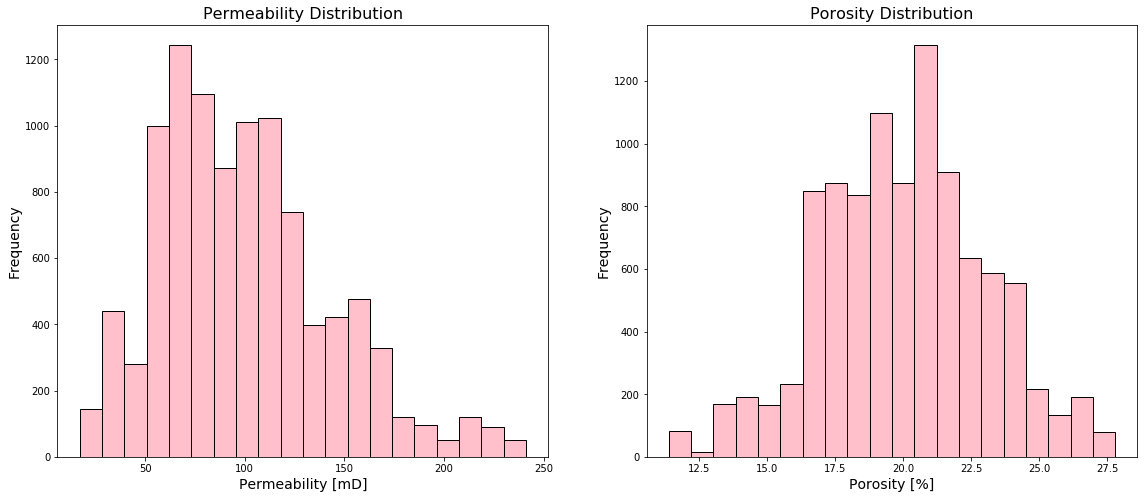

In [10]:
syntheticReservoir.plot_histogram()